GloVe embeddings already downloaded.
Epoch [1/20], Loss: 0.0564
Epoch [2/20], Loss: 0.0554
Epoch [3/20], Loss: 0.0548
Epoch [4/20], Loss: 0.0546
Epoch [5/20], Loss: 0.0544
Epoch [6/20], Loss: 0.0544
Epoch [7/20], Loss: 0.0543
Epoch [8/20], Loss: 0.0543
Epoch [9/20], Loss: 0.0542
Epoch [10/20], Loss: 0.0542
Epoch [11/20], Loss: 0.0539
Epoch [12/20], Loss: 0.0538
Epoch [13/20], Loss: 0.0538
Epoch [14/20], Loss: 0.0538
Epoch [15/20], Loss: 0.0536
Epoch [16/20], Loss: 0.0535
Epoch [17/20], Loss: 0.0531
Epoch [18/20], Loss: 0.0523
Epoch [19/20], Loss: 0.0516
Epoch [20/20], Loss: 0.0511


c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:14

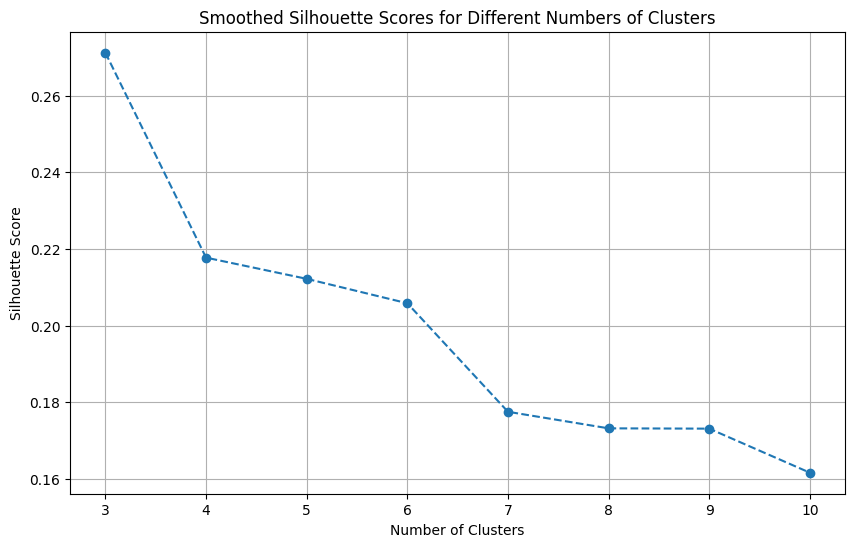

c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


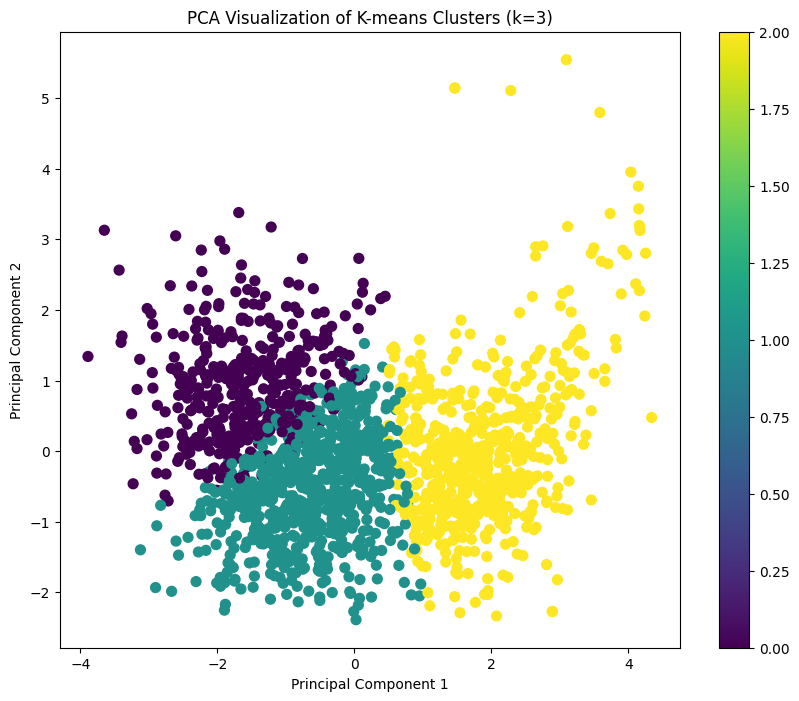

In [1]:
import numpy as np
import urllib.request
import zipfile
import os
import re
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_recall_fscore_support, accuracy_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import contingency_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords

torch.manual_seed(1219)

def download_glove():
    if not os.path.exists('./glove.6B.100d.txt'):
        print('Downloading GloVe embeddings...')
        url = 'http://nlp.stanford.edu/data/glove.6B.zip'
        urllib.request.urlretrieve(url, './glove.6B.zip')
        with zipfile.ZipFile('./glove.6B.zip', 'r') as zip_ref:
            zip_ref.extractall('./')
        print('GloVe embeddings downloaded and extracted.')
    else:
        print('GloVe embeddings already downloaded.')

def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^A-Za-z\s]', '', text)
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def load_glove_embeddings(embeddings_file):
    glove_embeddings = {}
    with open(embeddings_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings

def document_vector(doc, embeddings):
    tokens = doc.split()
    word_vectors = [embeddings[token] for token in tokens if token in embeddings]
    if not word_vectors:
        return np.zeros(embeddings['a'].shape)  
    return np.mean(word_vectors, axis=0)

download_glove()

categories = ['rec.sport.hockey', 'sci.space', 'sci.med']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

X_text = [preprocess(doc) for doc in newsgroups_train.data]

glove_file = './glove.6B.100d.txt'  # Assuming 100-dimensional GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file)
X_embeddings = np.array([document_vector(doc, glove_embeddings) for doc in X_text])

X_tensor = torch.tensor(X_embeddings, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = X_tensor.to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_tensor.shape[1]
latent_dim = 32  
autoencoder = Autoencoder(input_dim, latent_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 20
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(X_tensor), batch_size):
        inputs = X_tensor[i:i+batch_size].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    encoded_X = autoencoder.encoder(X_tensor).cpu().numpy()

silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_X)
    score = silhouette_score(encoded_X, kmeans.labels_)
    silhouette_scores.append(score)

window_size = 2
smoothed_scores = np.convolve(silhouette_scores, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(k_values[1:], smoothed_scores, marker='o', linestyle='--')
plt.title('Smoothed Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

optimal_k = k_values[1:][np.argmax(smoothed_scores)]

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(encoded_X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(encoded_X)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title(f'PCA Visualization of K-means Clusters (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()